### Animals photos classification with tensorflow

Images downloaded from Google with this program https://github.com/mklimek001/photos-downloader

In [124]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

In [125]:
tf.__version__

'2.11.0'

In [126]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Photos reading

In [127]:
base_dir = ".\downloaded_photos"

test_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

print(test_dir, train_dir, valid_dir)

.\downloaded_photos\test .\downloaded_photos\train .\downloaded_photos\valid


In [128]:
classes = os.listdir(train_dir)
classes

['monkey', 'parrot', 'snake']

In [147]:
from tensorflow.keras.utils import image_dataset_from_directory

def read_imgs(source_dir):
    return image_dataset_from_directory(
        directory=source_dir,
        batch_size=32,
        image_size=(150,150),
        labels='inferred')


In [148]:
train = read_imgs(train_dir)

Found 1219 files belonging to 3 classes.


In [149]:
train.element_spec

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [150]:
train.class_names

['monkey', 'parrot', 'snake']

In [239]:
test = read_imgs(test_dir)
valid = read_imgs(valid_dir)

Found 355 files belonging to 3 classes.
Found 180 files belonging to 3 classes.


In [153]:
def plot_images(iterator):
    plt.figure(figsize=(16, 16))
    for i in range(12):
        plt.subplot(4,3,i+1)
        batch = iterator.as_numpy_iterator().next()
        image = batch[0][0].astype('uint8')
        plt.imshow(image)

    plt.show()
    

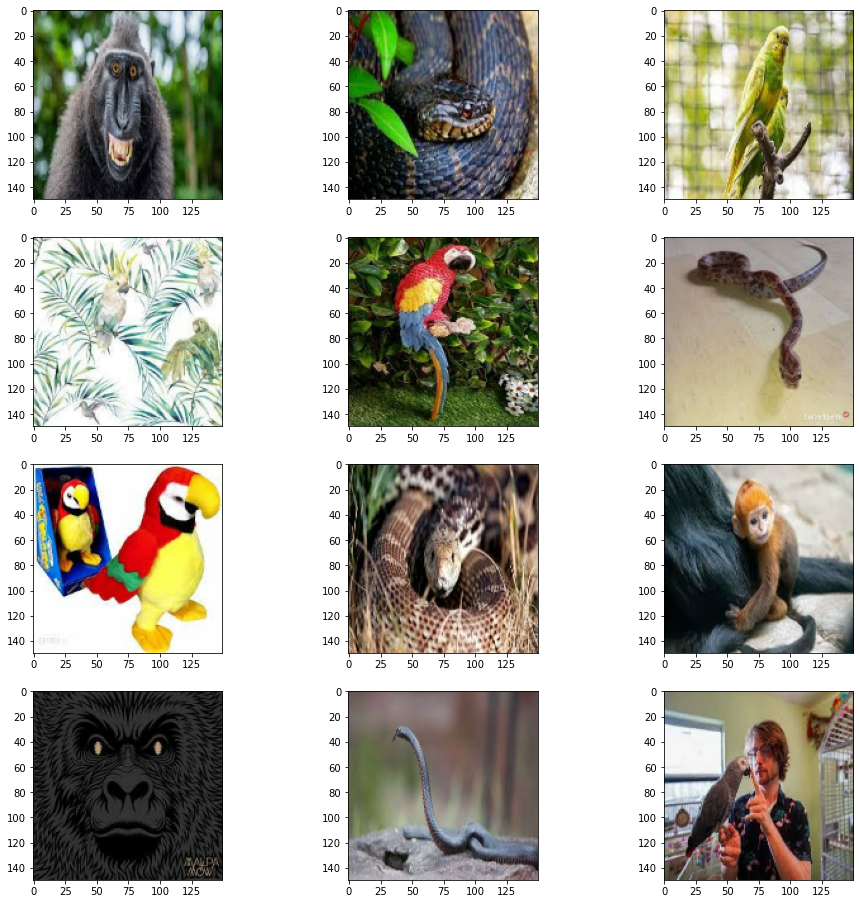

In [154]:
plot_images(train)

#### Simple model

In [208]:
simple_model = Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [209]:
simple_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 37, 37, 64)      

In [210]:
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [211]:
epochs = 20

history = simple_model.fit(train,
                    epochs=epochs, 
                    validation_data=valid)
     

Epoch 1/20
39/39 [==============================] - 10s 242ms/step - loss: 1.1682 - accuracy: 0.3757 - val_loss: 1.0552 - val_accuracy: 0.4889
Epoch 2/20
39/39 [==============================] - 9s 236ms/step - loss: 1.0211 - accuracy: 0.4635 - val_loss: 0.9881 - val_accuracy: 0.5167
Epoch 3/20
39/39 [==============================] - 9s 238ms/step - loss: 0.9522 - accuracy: 0.5496 - val_loss: 0.9740 - val_accuracy: 0.5500
Epoch 4/20
39/39 [==============================] - 9s 237ms/step - loss: 0.8708 - accuracy: 0.6153 - val_loss: 0.8792 - val_accuracy: 0.5611
Epoch 5/20
39/39 [==============================] - 9s 236ms/step - loss: 0.7516 - accuracy: 0.6751 - val_loss: 0.8763 - val_accuracy: 0.6167
Epoch 6/20
39/39 [==============================] - 9s 239ms/step - loss: 0.6023 - accuracy: 0.7580 - val_loss: 0.9860 - val_accuracy: 0.6444
Epoch 7/20
39/39 [==============================] - 9s 238ms/step - loss: 0.5180 - accuracy: 0.7982 - val_loss: 0.9068 - val_accuracy: 0.6278
Epoch

In [212]:
def validation_and_accuracy_graphs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

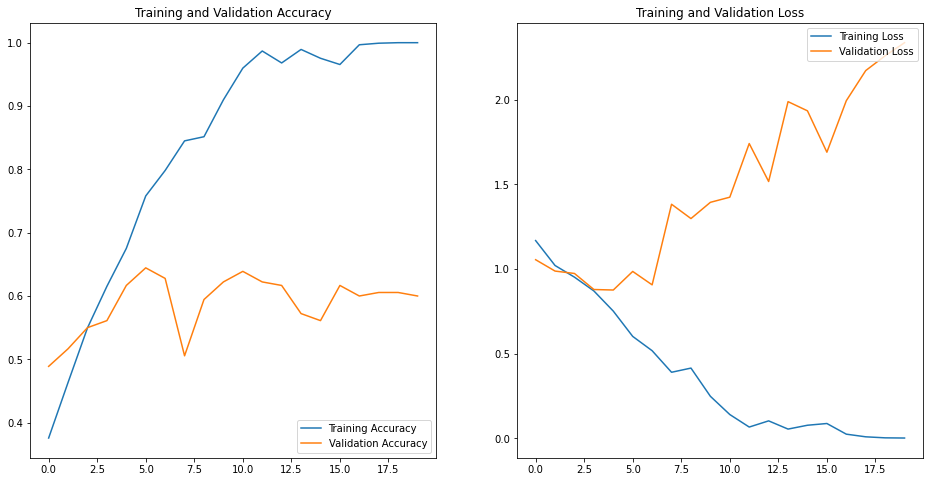

In [213]:
validation_and_accuracy_graphs(history, epochs)

#### Simple model upgrade

In [214]:
upgraded_model = Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [215]:
upgraded_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [216]:
history = upgraded_model.fit(train,
                    epochs=epochs, 
                    validation_data=valid)

Epoch 1/20
39/39 [==============================] - 12s 290ms/step - loss: 1.2713 - accuracy: 0.3806 - val_loss: 1.0915 - val_accuracy: 0.4222
Epoch 2/20
39/39 [==============================] - 11s 288ms/step - loss: 1.0630 - accuracy: 0.4110 - val_loss: 1.0118 - val_accuracy: 0.5111
Epoch 3/20
39/39 [==============================] - 11s 287ms/step - loss: 0.9848 - accuracy: 0.5291 - val_loss: 0.9417 - val_accuracy: 0.6056
Epoch 4/20
39/39 [==============================] - 11s 289ms/step - loss: 0.8986 - accuracy: 0.5906 - val_loss: 0.9150 - val_accuracy: 0.5611
Epoch 5/20
39/39 [==============================] - 11s 287ms/step - loss: 0.8729 - accuracy: 0.5956 - val_loss: 0.8728 - val_accuracy: 0.6222
Epoch 6/20
39/39 [==============================] - 11s 287ms/step - loss: 0.7943 - accuracy: 0.6382 - val_loss: 0.8610 - val_accuracy: 0.6222
Epoch 7/20
39/39 [==============================] - 12s 296ms/step - loss: 0.7708 - accuracy: 0.6628 - val_loss: 0.8812 - val_accuracy: 0.5833

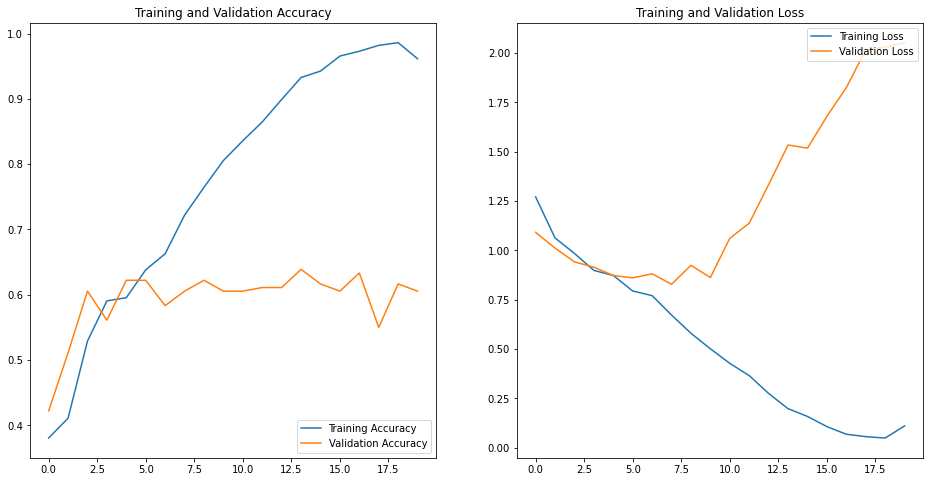

In [217]:
validation_and_accuracy_graphs(history, epochs)

#### Adding augmentation

In [220]:
data_augmentation = Sequential(
  [layers.RandomFlip("horizontal",input_shape=(150, 150, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

In [221]:
augmented_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [222]:
augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [223]:
history = augmented_model.fit(train,
                    epochs=epochs, 
                    validation_data=valid)

Epoch 1/20
39/39 [==============================] - 18s 343ms/step - loss: 1.1303 - accuracy: 0.3667 - val_loss: 1.0790 - val_accuracy: 0.4444
Epoch 2/20
39/39 [==============================] - 13s 334ms/step - loss: 1.0101 - accuracy: 0.5234 - val_loss: 0.9893 - val_accuracy: 0.5444
Epoch 3/20
39/39 [==============================] - 13s 341ms/step - loss: 0.9658 - accuracy: 0.5398 - val_loss: 0.9764 - val_accuracy: 0.5667
Epoch 4/20
39/39 [==============================] - 13s 333ms/step - loss: 0.9223 - accuracy: 0.5718 - val_loss: 0.9025 - val_accuracy: 0.5833
Epoch 5/20
39/39 [==============================] - 13s 334ms/step - loss: 0.8933 - accuracy: 0.5800 - val_loss: 0.8940 - val_accuracy: 0.5944
Epoch 6/20
39/39 [==============================] - 13s 330ms/step - loss: 0.8785 - accuracy: 0.5972 - val_loss: 0.8717 - val_accuracy: 0.5889
Epoch 7/20
39/39 [==============================] - 13s 328ms/step - loss: 0.8473 - accuracy: 0.6161 - val_loss: 0.8623 - val_accuracy: 0.5833

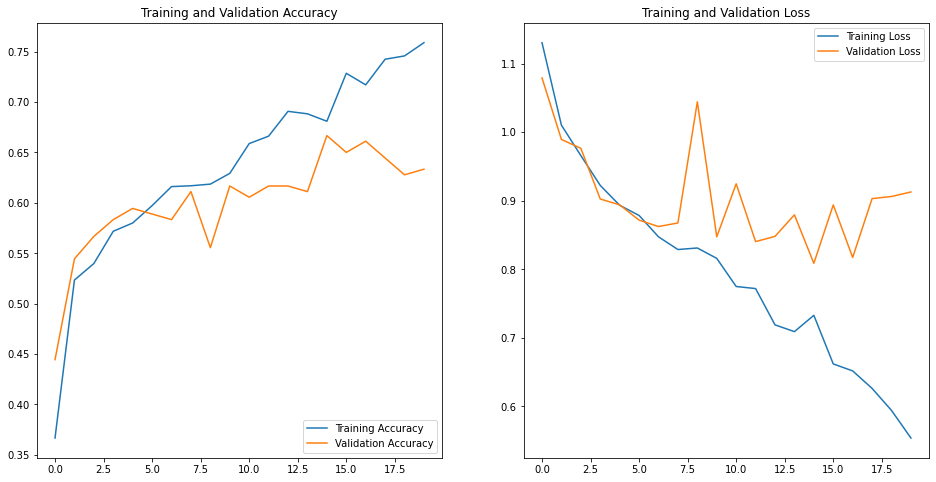

In [224]:
validation_and_accuracy_graphs(history, epochs)

In [295]:
real_classes = np.concatenate([y for x, y in test], axis=0)
test_imgs = np.concatenate([x for x, y in test], axis=0)

In [296]:
test_imgs[0].shape

(150, 150, 3)

In [315]:
predictions = augmented_model.predict(test_imgs[:10])

1/1 [==============================] - 0s 28ms/step


In [316]:
predictions

array([[0.05391581, 0.58685905, 0.35922506],
       [0.8274301 , 0.05651844, 0.11605151],
       [0.8697245 , 0.02442805, 0.10584738],
       [0.14904667, 0.04536281, 0.80559057],
       [0.72814685, 0.16830462, 0.1035485 ],
       [0.08639266, 0.40671334, 0.506894  ],
       [0.24636444, 0.2702239 , 0.48341167],
       [0.7326544 , 0.02972457, 0.237621  ],
       [0.09713928, 0.85350645, 0.04935429],
       [0.11612953, 0.33853397, 0.5453364 ]], dtype=float32)

In [317]:
predicted_classes = predictions.argmax(axis=-1)
predicted_classes

array([1, 0, 0, 2, 0, 2, 2, 0, 1, 2], dtype=int64)

In [318]:
real_classes[:10]

array([0, 0, 1, 2, 1, 2, 1, 0, 1, 2])

In [319]:
from sklearn.metrics import accuracy_score

accuracy_score(real_classes[:10], predicted_classes)

0.6

#### VGG Model

In [320]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [321]:
vgg19_layers = vgg19.layers
vgg19_l_names = [l.name for l in vgg19_layers]
vgg19_l_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [322]:
def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:16} trainable: {layer.trainable}')

print_layers(vgg19)

layer_name: input_2          trainable: True
layer_name: block1_conv1     trainable: True
layer_name: block1_conv2     trainable: True
layer_name: block1_pool      trainable: True
layer_name: block2_conv1     trainable: True
layer_name: block2_conv2     trainable: True
layer_name: block2_pool      trainable: True
layer_name: block3_conv1     trainable: True
layer_name: block3_conv2     trainable: True
layer_name: block3_conv3     trainable: True
layer_name: block3_conv4     trainable: True
layer_name: block3_pool      trainable: True
layer_name: block4_conv1     trainable: True
layer_name: block4_conv2     trainable: True
layer_name: block4_conv3     trainable: True
layer_name: block4_conv4     trainable: True
layer_name: block4_pool      trainable: True
layer_name: block5_conv1     trainable: True
layer_name: block5_conv2     trainable: True
layer_name: block5_conv3     trainable: True
layer_name: block5_conv4     trainable: True
layer_name: block5_pool      trainable: True


In [323]:
for layer in vgg19_layers:
    if "block5" not in layer.name:
        layer.trainable = False
        
print_layers(vgg19)

layer_name: input_2          trainable: False
layer_name: block1_conv1     trainable: False
layer_name: block1_conv2     trainable: False
layer_name: block1_pool      trainable: False
layer_name: block2_conv1     trainable: False
layer_name: block2_conv2     trainable: False
layer_name: block2_pool      trainable: False
layer_name: block3_conv1     trainable: False
layer_name: block3_conv2     trainable: False
layer_name: block3_conv3     trainable: False
layer_name: block3_conv4     trainable: False
layer_name: block3_pool      trainable: False
layer_name: block4_conv1     trainable: False
layer_name: block4_conv2     trainable: False
layer_name: block4_conv3     trainable: False
layer_name: block4_conv4     trainable: False
layer_name: block4_pool      trainable: False
layer_name: block5_conv1     trainable: True
layer_name: block5_conv2     trainable: True
layer_name: block5_conv3     trainable: True
layer_name: block5_conv4     trainable: True
layer_name: block5_pool      trainable

In [328]:
model = Sequential()
model.add(data_augmentation,)
model.add(layers.Rescaling(1./255))
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

In [329]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_18 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_18 (Flatten)        (None, 8192)              0         
                                                                 
 dense_38 (Dense)            (None, 128)               1048704   
                                                                 
 dense_39 (Dense)            (None, 3)                 387       
                                                                 
Total params: 21,073,475
Trainable params: 10,488,323

In [331]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [332]:
history = model.fit(train,
                    epochs=10, 
                    validation_data=valid)

Epoch 1/10
39/39 [==============================] - 87s 2s/step - loss: 1.0987 - accuracy: 0.3158 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/10
39/39 [==============================] - 81s 2s/step - loss: 1.0987 - accuracy: 0.3240 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/10
39/39 [==============================] - 81s 2s/step - loss: 1.0987 - accuracy: 0.3183 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/10
39/39 [==============================] - 78s 2s/step - loss: 1.2307 - accuracy: 0.3445 - val_loss: 2.4688 - val_accuracy: 0.3333
Epoch 5/10
39/39 [==============================] - 79s 2s/step - loss: 1.1549 - accuracy: 0.3831 - val_loss: 1.0475 - val_accuracy: 0.4056
Epoch 6/10
39/39 [==============================] - 78s 2s/step - loss: 0.9617 - accuracy: 0.5431 - val_loss: 0.8317 - val_accuracy: 0.5889
Epoch 7/10
39/39 [==============================] - 78s 2s/step - loss: 0.7523 - accuracy: 0.6981 - val_loss: 0.6221 - val_accuracy: 0.7444
Epoch 8/10
39/39 [==

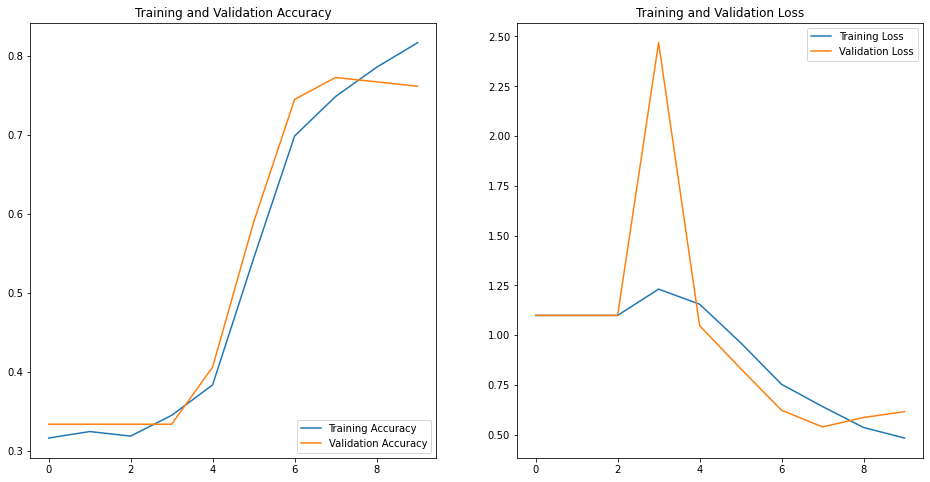

In [335]:
validation_and_accuracy_graphs(history, 10)